In [8]:
#imports
from IPython.display import display, clear_output
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import streaming
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline 

In [9]:
#spark driver
spark = SparkSession.builder.appName("StructuredStreamingTwitterSpark").getOrCreate()

In [10]:
#plot function
def display_barplot(spark_df, x, y, time, scale=2.0, size=(16, 9)):
    """Displays a Spark DataFrame's contents as a bar plot."""
    df = spark_df.toPandas()
    
    # remove prior graph when new one is ready to display
    print(f'TIME: {time}')
    
    # create and configure a Figure containing a Seaborn barplot 
    plt.figure(figsize=size)
    sns.set(font_scale=scale)
    barplot = sns.barplot(data=df, x=x, y=y, 
                          palette=sns.color_palette('cool', 20))
    
    # rotate the x-axis labels 90 degrees for readability
    for item in barplot.get_xticklabels():
        item.set_rotation(90)
        
    plt.tight_layout()
    plt.show()

In [11]:
"""EXTRACT"""

#SparkStreamReader created listening on the socket 
#to which twitter is sending the tweets from
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9876) \
    .load()

"""TRANSFORM"""

# Split each tweet into specific rows for a given word
words = lines.select(
       f.explode(
           f.split(lines.value, "\s+")
                   ).alias("word")
    )

#counts the number of times a word comes up
#filters the tweets that come in without a hashtag
wordCounts = words.filter(f.col("word") != "").groupBy("word").count()

"""LOAD"""

#stores the complete dataframe into memory every 2 seconds 
stream_writer = wordCounts \
    .writeStream \
    .queryName("wordCounts") \
    .trigger(processingTime='2 seconds') \
    .outputMode("complete") \
    .format("memory") \

#transforms a DataStreamWriter into StreamingQuery object
query = stream_writer.start()

In [12]:
#display the word and count
display(spark.sql(f"SELECT * from {query.name}").toPandas())

,word,count
0,olympics2021,1
1,america,1
2,nationalinternday,1
3,fbi,4
4,nacionales,1
5,simonebiles,1
6,variantedelta,1
7,olympics,1
8,fauci,1
9,prospere,1


In [13]:
# show a plot of the top 20 hashtags for 2 minutes, refreshed every 2 second
from time import sleep
for x in range(0, 120):
    # use spark.sql to get the top 20 words by count
    top20_df = spark.sql(f"""SELECT word, count
                       FROM {query.name}
                       WHERE word != ' '
                       ORDER BY count DESC, word ASC
                       LIMIT 20
                        """
                        )
    #display a seaborn plot of the top 20 words
    display_barplot(top20_df, x='word', y='count', time=query.lastProgress['timestamp'][0:10])
    
    #break for 2 seconds before showing the next plot
    sleep(2)
    clear_output(wait=True)
else:
    print("Live view ended...")

Live view ended...


TIME: 2021-07-29


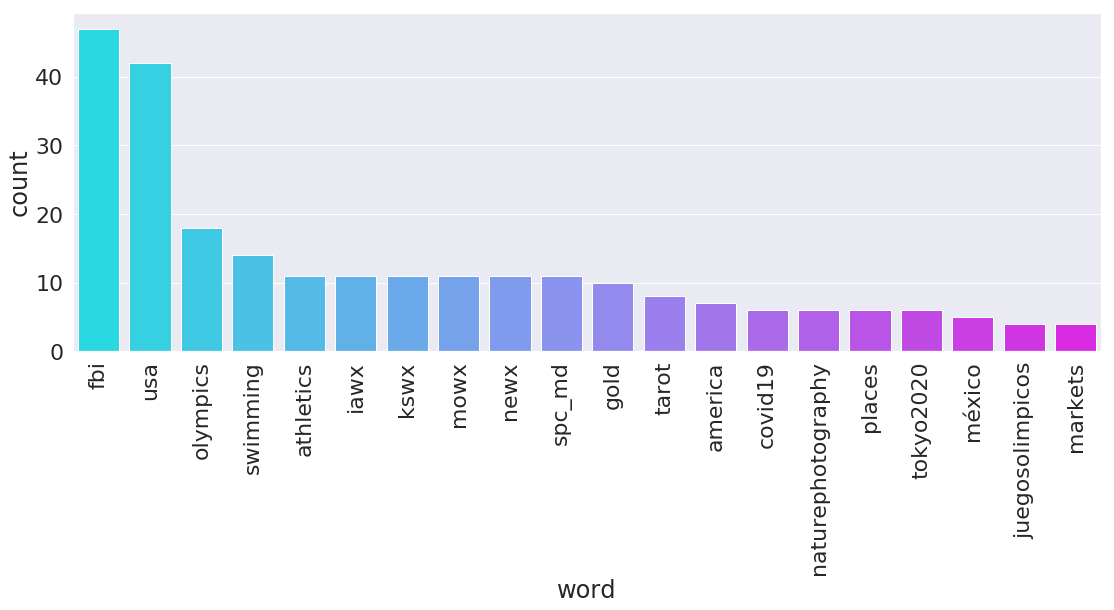

In [14]:
#the final plot
display_barplot(top20_df, x='word', y='count', time=query.lastProgress['timestamp'][0:10])

In [6]:
#stops the query 
query.stop()

In [7]:
#stops the spark program
spark.stop()